# Mental Health Model Experimentation

**Location:** `0 try/experiment.ipynb`

**Outputs to:** `../3-cicd/`

**Goal:** Find the best model, hyperparameters, and features

**Output:** `best_config.json` in `3-cicd/` folder for `train.py`

In [ ]:
# Setup and imports
import os
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import mlflow

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

OUTPUT_DIR = Path('../3-cicd')
OUTPUT_DIR.mkdir(exist_ok=True)

MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI', 'file:../mlruns')
MLFLOW_EXPERIMENT_NAME = os.getenv("MLFLOW_EXPERIMENT_NAME", "mental-health-tech-prediction")
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

print('✓ Libraries imported')
print(f'✓ Output: {OUTPUT_DIR.absolute()}')
print(f'✓ MLflow tracking: {MLFLOW_TRACKING_URI}')
print(f'✓ MLflow experiment: {MLFLOW_EXPERIMENT_NAME}')

✓ Libraries imported
✓ Output: c:\Users\dell\OneDrive\Documentos\MLOPS\0-try\..\3-cicd
✓ MLflow tracking: file:../3-cicd/mlruns
✓ MLflow experiment: mental-health-tech-prediction


In [57]:
# Load data
df = pd.read_csv('../data/raw/survey.csv')
print(f'Dataset: {df.shape}')
df.head()

Dataset: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [58]:
# Preprocessing
def clean_gender(gen):
    s = str(gen).strip().lower()
    s = re.sub(r'[\W_]+', ' ', s).strip()
    if s in {'m','male','man','make','mal','malr','msle','masc','mail','boy'}:
        return 'Male'
    if s in {'f','female','woman','femake','femail','femme','girl'}:
        return 'Female'
    return 'Other'

target_col = 'treatment'
features_to_drop = ['Timestamp','Country','state','comments',target_col]

y = df[target_col].map({'Yes':1,'No':0}).astype(int)
X = df.drop(columns=features_to_drop)
if 'Gender' in X.columns:
    X['Gender'] = X['Gender'].apply(clean_gender)

print(f'Features: {X.shape[1]}')
print(f'Samples: {X.shape[0]}')
print('\nTarget distribution:')
print(y.value_counts(normalize=True))

Features: 22
Samples: 1259

Target distribution:
treatment
1    0.505957
0    0.494043
Name: proportion, dtype: float64


In [59]:
# Define models
models_to_test = {
    'LogisticRegression': {
        'model': LogisticRegression(solver='liblinear',max_iter=5000,random_state=42),
        'params': {'C':1.0,'penalty':'l2'}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators':300,'max_depth':10,'min_samples_split':2,'class_weight':'balanced'}
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {'n_estimators':400,'max_depth':6,'learning_rate':0.01,'subsample':0.8,'colsample_bytree':1.0,'scale_pos_weight':1.26}
    }
}

print('Models to test:')
for name in models_to_test:
    print(f'  - {name}')

Models to test:
  - LogisticRegression
  - RandomForest
  - XGBoost


In [60]:
# Build preprocessor
def build_preprocessor(X):
    num_cols = X.select_dtypes(include=['number','bool']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
    num_pipe = Pipeline([('impute',SimpleImputer(strategy='median')),('scale',StandardScaler())])
    cat_pipe = Pipeline([('impute',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))])
    return ColumnTransformer([('num',num_pipe,num_cols),('cat',cat_pipe,cat_cols)],remainder='drop')

preprocessor = build_preprocessor(X)
print('✓ Preprocessor ready')

✓ Preprocessor ready


In [61]:
# Cross-validation
print('='*70)
print('CROSS-VALIDATION')
print('='*70)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scoring = {'recall':'recall','precision':'precision','f1':'f1','roc_auc':'roc_auc','fbeta':make_scorer(fbeta_score,beta=1.5)}
mlflow_cv_tags = {'stage':'cross-validation','source_notebook':'0-try/experiment.ipynb'}

results = []
for name,config in models_to_test.items():
    print(f'\n🔄 {name}...')
    model = config['model']
    model.set_params(**config['params'])
    pipe = Pipeline([('preprocess',preprocessor),('model',model)])
    cv_results = cross_validate(pipe,X,y,cv=cv,scoring=scoring,n_jobs=-1,return_train_score=False)
    result = {
        'model':name,
        'recall_mean':cv_results['test_recall'].mean(),
        'recall_std':cv_results['test_recall'].std(),
        'precision_mean':cv_results['test_precision'].mean(),
        'precision_std':cv_results['test_precision'].std(),
        'f1_mean':cv_results['test_f1'].mean(),
        'f1_std':cv_results['test_f1'].std(),
        'fbeta_mean':cv_results['test_fbeta'].mean(),
        'fbeta_std':cv_results['test_fbeta'].std(),
        'roc_auc_mean':cv_results['test_roc_auc'].mean(),
        'roc_auc_std':cv_results['test_roc_auc'].std()
    }
    cv_payload = {
        'recall':cv_results['test_recall'].tolist(),
        'precision':cv_results['test_precision'].tolist(),
        'f1':cv_results['test_f1'].tolist(),
        'fbeta':cv_results['test_fbeta'].tolist(),
        'roc_auc':cv_results['test_roc_auc'].tolist()
    }
    with mlflow.start_run(run_name=f"{name}-cv", tags={**mlflow_cv_tags,'model_name':name}):
        mlflow.log_param('model', name)
        mlflow.log_param('cv_splits', cv.get_n_splits())
        mlflow.log_param('n_features', X.shape[1])
        mlflow.log_params(config['params'])
        mlflow.log_metrics({
            'recall_mean':result['recall_mean'],
            'recall_std':result['recall_std'],
            'precision_mean':result['precision_mean'],
            'precision_std':result['precision_std'],
            'f1_mean':result['f1_mean'],
            'f1_std':result['f1_std'],
            'fbeta_mean':result['fbeta_mean'],
            'fbeta_std':result['fbeta_std'],
            'roc_auc_mean':result['roc_auc_mean'],
            'roc_auc_std':result['roc_auc_std']
        })
        mlflow.log_dict(cv_payload,f'artifacts/{name}_cv_scores.json')
        result['run_id'] = mlflow.active_run().info.run_id
    results.append(result)
    print(f"  Recall:    {result['recall_mean']:.3f} ± {result['recall_std']:.3f}")
    print(f"  Precision: {result['precision_mean']:.3f} ± {result['precision_std']:.3f}")
    print(f"  F-beta:    {result['fbeta_mean']:.3f} ± {result['fbeta_std']:.3f}")

CROSS-VALIDATION

🔄 LogisticRegression...
  Recall:    0.741 ± 0.022
  Precision: 0.749 ± 0.024
  F-beta:    0.743 ± 0.019

🔄 RandomForest...
  Recall:    0.747 ± 0.032
  Precision: 0.763 ± 0.025
  F-beta:    0.752 ± 0.029

🔄 XGBoost...
  Recall:    0.785 ± 0.029
  Precision: 0.734 ± 0.022
  F-beta:    0.768 ± 0.024



RESULTS
             model  recall_mean  precision_mean  fbeta_mean
           XGBoost     0.784904        0.734393    0.768485
      RandomForest     0.747306        0.762838    0.751902
LogisticRegression     0.741043        0.748599    0.743138

🏆 Best: XGBoost
🔗 MLflow run: a5580655d4c440c2bbbe974951092f16


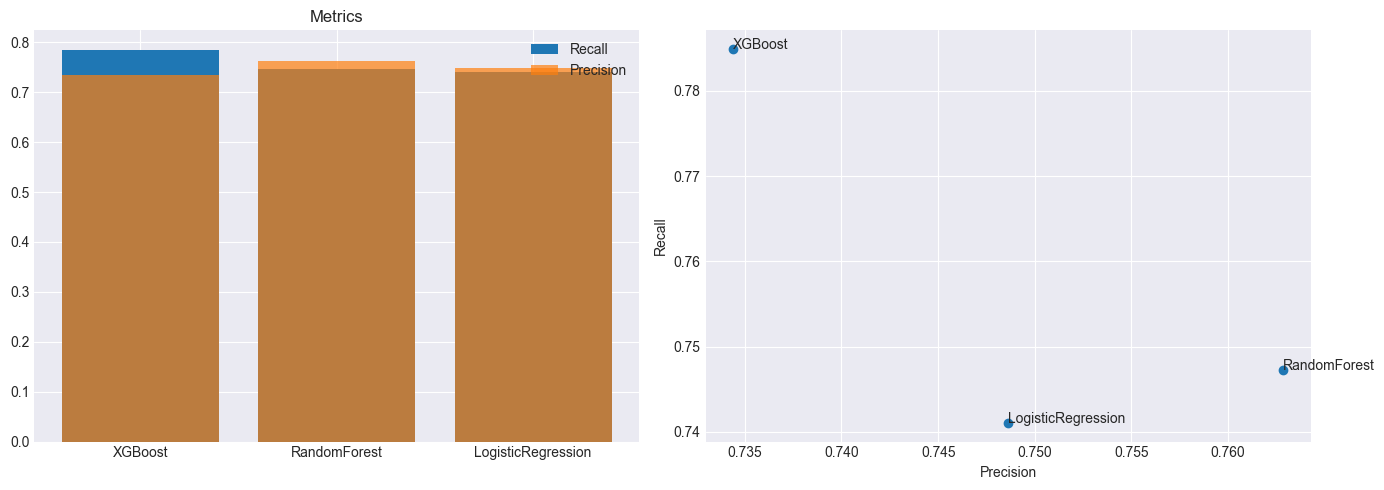

✓ Saved: ..\3-cicd\model_comparison.png


In [62]:
# Results
results_df = pd.DataFrame(results).sort_values('fbeta_mean',ascending=False).reset_index(drop=True)
print('\n'+'='*70)
print('RESULTS')
print('='*70)
print(results_df[['model','recall_mean','precision_mean','fbeta_mean']].to_string(index=False))
best_model_name = results_df.iloc[0]['model']
BEST_RUN_ID = results_df.iloc[0]['run_id']
print(f'\n🏆 Best: {best_model_name}')
print(f'🔗 MLflow run: {BEST_RUN_ID}')

# Plot
fig,ax = plt.subplots(1,2,figsize=(14,5))
x = np.arange(len(results_df))
ax[0].bar(x,results_df['recall_mean'],label='Recall')
ax[0].bar(x,results_df['precision_mean'],alpha=0.7,label='Precision')
ax[0].set_xticks(x)
ax[0].set_xticklabels(results_df['model'])
ax[0].legend()
ax[0].set_title('Metrics')
ax[1].scatter(results_df['precision_mean'],results_df['recall_mean'])
for _,row in results_df.iterrows():
    ax[1].annotate(row['model'],(row['precision_mean'],row['recall_mean']))
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
plt.tight_layout()
comparison_path = OUTPUT_DIR/'model_comparison.png'
plt.savefig(comparison_path,dpi=150)
plt.show()
print(f'✓ Saved: {comparison_path}')

with mlflow.start_run(run_id=BEST_RUN_ID):
    mlflow.set_tags({'stage':'analysis','best_model':best_model_name})
    mlflow.log_dict(json.loads(results_df.to_json(orient='records')),'cv_summary.json')
    mlflow.log_artifact(str(comparison_path))

In [63]:
# Feature importance
print('='*70)
print('FEATURE SELECTION')
print('='*70)

best_config = models_to_test[best_model_name]
best_model = best_config['model']
best_model.set_params(**best_config['params'])

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
pipe = Pipeline([('preprocess',preprocessor),('model',best_model)])
pipe.fit(X_train,y_train)

perm = permutation_importance(pipe.named_steps['model'],pipe.named_steps['preprocess'].transform(X_val),y_val,n_repeats=10,random_state=42,n_jobs=-1)

try:
    feat_names = pipe.named_steps['preprocess'].get_feature_names_out()
except:
    feat_names = [f'f_{i}' for i in range(len(perm.importances_mean))]

orig_imp = {}
for col in X.columns:
    imp = [perm.importances_mean[i] for i,f in enumerate(feat_names) if col.lower() in f.lower()]
    orig_imp[col] = max(imp) if imp else 0.0

imp_df = pd.DataFrame([{'feature':k,'importance':v} for k,v in orig_imp.items()]).sort_values('importance',ascending=False)
print('\nTop features:')
print(imp_df.head(10).to_string(index=False))

with mlflow.start_run(run_id=BEST_RUN_ID):
    mlflow.log_dict(json.loads(imp_df.to_json(orient='records')),'feature_importance.json')

FEATURE SELECTION

Top features:
                feature  importance
         work_interfere    0.076190
         family_history    0.030952
           care_options    0.029365
             supervisor    0.010317
                  leave    0.008730
                 Gender    0.007540
        obs_consequence    0.007143
mental_health_interview    0.005952
           no_employees    0.005952
              coworkers    0.005159



Threshold: 0.001
Selected: 13
Removed: 9

Removed: ['remote_work', 'phys_health_consequence', 'anonymity', 'wellness_program', 'benefits', 'mental_vs_physical', 'tech_company', 'seek_help', 'Age']


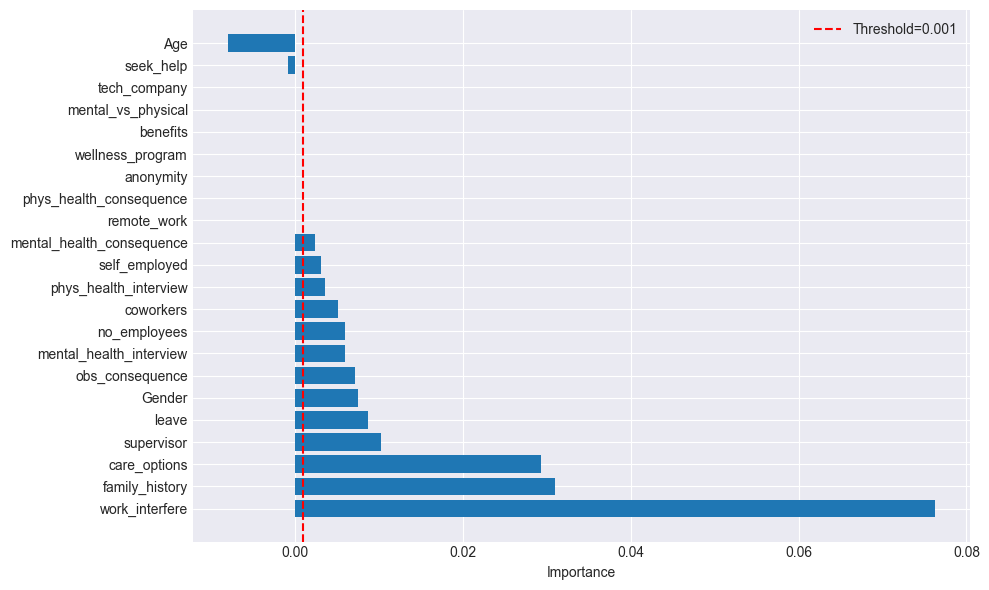

✓ Saved: ..\3-cicd\feature_importance.png


In [64]:
# Feature selection
thresh = 0.001
selected = imp_df[imp_df['importance']>thresh]['feature'].tolist()
removed = imp_df[imp_df['importance']<=thresh]['feature'].tolist()

print(f'\nThreshold: {thresh}')
print(f'Selected: {len(selected)}')
print(f'Removed: {len(removed)}')
if removed:
    print(f'\nRemoved: {removed}')

plt.figure(figsize=(10,6))
plt.barh(imp_df['feature'],imp_df['importance'])
plt.axvline(thresh,color='red',linestyle='--',label=f'Threshold={thresh}')
plt.xlabel('Importance')
plt.legend()
plt.tight_layout()
feature_imp_path = OUTPUT_DIR/'feature_importance.png'
plt.savefig(feature_imp_path,dpi=150)
plt.show()
print(f'✓ Saved: {feature_imp_path}')

selection_payload = {
    'threshold':thresh,
    'selected':selected,
    'removed':removed
}
with mlflow.start_run(run_id=BEST_RUN_ID):
    mlflow.log_metric('selected_feature_count', len(selected))
    mlflow.log_metric('removed_feature_count', len(removed))
    mlflow.log_dict(selection_payload,'feature_selection.json')
    mlflow.log_artifact(str(feature_imp_path))

In [65]:
# Final evaluation
X_sel = X[selected].copy()
pipe_final = Pipeline([('preprocess',build_preprocessor(X_sel)),('model',best_model)])
cv_final = cross_validate(pipe_final,X_sel,y,cv=cv,scoring=scoring,n_jobs=-1)

final_metrics = {
    'final_recall_mean':cv_final['test_recall'].mean(),
    'final_precision_mean':cv_final['test_precision'].mean(),
    'final_fbeta_mean':cv_final['test_fbeta'].mean(),
    'final_roc_auc_mean':cv_final['test_roc_auc'].mean()
}

print('\nFinal CV:')
print(f"  Recall:    {final_metrics['final_recall_mean']:.3f}")
print(f"  Precision: {final_metrics['final_precision_mean']:.3f}")
print(f"  F-beta:    {final_metrics['final_fbeta_mean']:.3f}")

with mlflow.start_run(run_id=BEST_RUN_ID):
    mlflow.log_metrics(final_metrics)
    mlflow.log_metric('final_cv_std_recall', cv_final['test_recall'].std())
    mlflow.log_metric('final_cv_std_precision', cv_final['test_precision'].std())
    mlflow.log_metric('final_cv_std_fbeta', cv_final['test_fbeta'].std())
    mlflow.log_metric('final_cv_std_roc_auc', cv_final['test_roc_auc'].std())


Final CV:
  Recall:    0.794
  Precision: 0.738
  F-beta:    0.776


In [66]:
# Save config
config = {
    'model':{'name':best_model_name,'class':best_model_name,'hyperparameters':best_config['params']},
    'features':{'selected':selected,'removed':removed,'importance_threshold':thresh},
    'performance':{
        'cv_recall_mean':float(cv_final['test_recall'].mean()),
        'cv_recall_std':float(cv_final['test_recall'].std()),
        'cv_precision_mean':float(cv_final['test_precision'].mean()),
        'cv_precision_std':float(cv_final['test_precision'].std()),
        'cv_f1_mean':float(cv_final['test_f1'].mean()),
        'cv_f1_std':float(cv_final['test_f1'].std()),
        'cv_fbeta_mean':float(cv_final['test_fbeta'].mean()),
        'cv_fbeta_std':float(cv_final['test_fbeta'].std()),
        'cv_roc_auc_mean':float(cv_final['test_roc_auc'].mean()),
        'cv_roc_auc_std':float(cv_final['test_roc_auc'].std())
    },
    'targets':{'min_recall':0.80,'min_precision':0.65,'beta':1.5}
}

path = OUTPUT_DIR/'best_config.json'
with open(path,'w') as f:
    json.dump(config,f,indent=2)

with mlflow.start_run(run_id=BEST_RUN_ID):
    mlflow.log_artifact(str(path))
    mlflow.log_dict(config,'best_config_snapshot.json')
    mlflow.set_tags({'stage':'best-config','ready_for_train':'true'})

print('='*70)
print('SAVED')
print('='*70)
print(f'✓ {path}')
print(f'\nModel: {best_model_name}')
print(f'Features: {len(selected)}')
print(f"Recall: {config['performance']['cv_recall_mean']:.1%}")
print(f"Precision: {config['performance']['cv_precision_mean']:.1%}")
print('\n🚀 Ready for: cd ../3-cicd && python train.py')

SAVED
✓ ..\3-cicd\best_config.json

Model: XGBoost
Features: 13
Recall: 79.4%
Precision: 73.8%

🚀 Ready for: cd ../3-cicd && python train.py


In [68]:
   print("Tracking URI:", mlflow.get_tracking_uri())
   exp = mlflow.get_experiment_by_name("mental-health-tech-prediction")
   print("Experiment:", exp.experiment_id if exp else "missing")

Tracking URI: file:../3-cicd/mlruns
Experiment: 880083778201046339
